### Machine translation

In [ ]:
!pip show torch torchtext

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision


In [1]:
!pip install torch==2.0.1 torchtext==0.15.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Preprocessing

In [3]:
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
import re

def preprocess_and_remove_punctuation(text):
    if text is not None:
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text
    else:
        return ""  # Return empty string for None values

# Tokenization and Lowercasing
def preprocess(sentences):
    tokenized_sentences = [
        nltk.word_tokenize(preprocess_and_remove_punctuation(sentence.lower() if sentence is not None else ""))
        for sentence in sentences
    ]
    return tokenized_sentences

In [4]:
def encode_and_pad(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sent) < max_length - 2: # -2 for SOS and EOS
        n_pads = max_length - 2 - len(sent)
        encoded = [vocab[w] for w in sent]
        return sos + encoded + eos + pad * n_pads
    else: # sent is longer than max_length; truncating
        encoded = [vocab[w] for w in sent]
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
hidden_size = 128
seq_length = 20
batch_size = 50

# Encoder and Decoder with LSTM

In [8]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded, hidden)
        return output, (hidden, cell)

    def initHidden(self, batch_size):  # Corrected to accept batch_size
        device = next(self.parameters()).device
        hidden = torch.zeros(1, batch_size, self.hidden_size, device=device)
        cell = torch.zeros(1, batch_size, self.hidden_size, device=device)
        return hidden, cell

In [9]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=False)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

# Loading the data

In [6]:
import json

# Open the file in read mode ('r')
with open('train_data1.json', 'r') as file:
    # Load JSON data from the file
    train_data = json.load(file)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In testing phase, substitute val_data1.json with test_data1_final.json

In [7]:
import json

# Open the file in read mode ('r')
with open('test_data1_final.json', 'r') as file:
    # Load JSON data from the file
    val_data = json.load(file)

In [8]:
for language_pair, language_data in train_data.items():
  print(f"Language Pair: {language_pair}")

Language Pair: English-Bengali
Language Pair: English-Hindi


# English --> Hindi

In [9]:
# Prepare training and validation data
source_sentences_train = []
target_sentences_train = []
source_sentences_val = []
target_sentences_val = []
id_train = []
id_val = []

In [10]:
for language_pair, language_data in train_data.items():
    if language_pair == "English-Hindi":
        for data_type, data_entries in language_data.items():
            for entry_id, entry_data in data_entries.items():
                source = entry_data["source"]
                target = entry_data["target"]
                if data_type == "Validation":
                    source_sentences_val.append(source)
                    target_sentences_val.append(target)
                    id_val.append(entry_id)
                else:
                    source_sentences_train.append(source)
                    target_sentences_train.append(target)
                    id_train.append(entry_id)

In [11]:
for language_pair, language_data in val_data.items():
    if(language_pair == "English-Hindi"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              #target = entry_data["target"]
              if (data_type == "Test"):
                source_sentences_val.append(source)
                #target_sentences_val.append(target)
                #id_val.append(entry_id)
              #else:
                #source_sentences_train.append(source)
                #target_sentences_train.append(target)
                #id_train.append(entry_id)

Language Pair: English-Hindi
  Data Type: Test


In [12]:
print(len(source_sentences_train))
print(len(target_sentences_train))

print(len(source_sentences_val))
print(len(target_sentences_val))

80797
80797
23085
0


In [13]:
val_h = pd.DataFrame({'English':source_sentences_val, 'Hindi': [None]*len(source_sentences_val)})

In [14]:
val_h

,English,Hindi
0,And then we need to assure students that a com...,None
1,what is the address for the event scheduled on...,None
2,Indira Gandhi National Park is spread in an ar...,None
3,Local musicians also attracted the King's atte...,None
4,"Of course, do some more stuff on this.",None
...,...,...
23080,send an email to peter and ask him how is he n...,None
23081,"At Bose ' s initiative , the Government of Ori...",None
23082,"v.After initial opening, store H2O2 at 4oC in ...",None
23083,Holding the claw of the left leg with both han...,None


In [15]:
x={'English':source_sentences_train,'Hindi':target_sentences_train}

In [16]:
df_h = pd.DataFrame(x)

In [17]:
df_h

,English,Hindi
0,cancel everything on my calendar,मेरे कैलेंडर पर सब कुछ रद्द करें
1,Adrenal hormone levels are at their peak durin...,अधिवृक्क के हार्मोन का स्तर प्रातःकाल में अपने...
2,"Golden threads are obtained from Surat, the qu...","स्वर्ण धागे सूरत से प्राप्त होते हैं, जिनकी गु..."
3,Look for agglutination within 30 seconds.,30 सेकेण्ड के भीतर एग्लूटिनेशन देखें।
4,The non-pompousness and informality of their l...,उनके जीवन की आडंबरहीनता एवं अनौपचारिकता उनके स...
...,...,...
80792,"So, is it that this is the optimization proble...","तो, यह अनुकूलन समस्या है जिसमें हम रुचि रखते थे।"
80793,In this Masjid made with red stones there are ...,लाल पत्थरों से बनायी गयी इस मस्जिद में हिन्दू ...
80794,"He began to work on the movie on August 17, 20...","उन्होंने 17 अगस्त, 2010 को फिल्म पर काम करना श..."
80795,start a new shopping list,एक नई खरीदारी सूची शुरू करें


In [23]:
nltk.download('punkt_tab')
english_tokens_h = preprocess(df_h['English'])
english_test_h =preprocess(val_h['English'])
hindi_tokens = preprocess(df_h['Hindi'])
hindi_test = preprocess(val_h['Hindi'])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [24]:
# en - English, hi - Hindi
en_train_h = english_tokens_h
en_test_h = english_test_h
hi_train = hindi_tokens
hi_test = hindi_test

In [25]:
en_index2word_h = ["<PAD>", "<SOS>", "<EOS>"]
hi_index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [en_train_h, en_test_h]:
    for sent in ds:
        for token in sent:
            if token not in en_index2word_h:
                en_index2word_h.append(token)

for ds in [hi_train, hi_test]:
    for sent in ds:
        for token in sent:
            if token not in hi_index2word:
                hi_index2word.append(token)

In [26]:
en_word2index_h = {token: idx for idx, token in enumerate(en_index2word_h)}
hi_word2index = {token: idx for idx, token in enumerate(hi_index2word)}

In [27]:
en_lengths_h = sum([len(sent) for sent in en_train_h])/len(en_train_h)
hi_lengths = sum([len(sent) for sent in hi_train])/len(hi_train)

In [28]:
en_train_encoded_h = [encode_and_pad(en_word2index_h, sent, seq_length) for sent in en_train_h]
en_test_encoded_h = [encode_and_pad(en_word2index_h, sent, seq_length) for sent in en_test_h]
hi_train_encoded = [encode_and_pad(hi_word2index, sent, seq_length) for sent in hi_train]
hi_test_encoded = [encode_and_pad(hi_word2index, sent, seq_length) for sent in hi_test]

In [29]:
batch_size = 50

train_x_h = np.array(en_train_encoded_h)
train_y_h = np.array(hi_train_encoded)
test_x_h = np.array(en_test_encoded_h)
test_y_h = np.array(hi_test_encoded)

train_ds_h = TensorDataset(torch.from_numpy(train_x_h), torch.from_numpy(train_y_h))
test_ds_h = TensorDataset(torch.from_numpy(test_x_h))


train_dl_h = DataLoader(train_ds_h, shuffle=True, batch_size=batch_size, drop_last=True)
#test_dl_h = DataLoader(test_ds_h, shuffle=True, batch_size=batch_size, drop_last=True)

In [30]:
encoder = EncoderLSTM(len(en_index2word_h), hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, len(hi_index2word)).to(device)

In [31]:
encoder

EncoderLSTM(
  (embedding): Embedding(69484, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
)

In [32]:
decoder

DecoderLSTM(
  (embedding): Embedding(49078, 128, padding_idx=0)
  (lstm): LSTM(128, 128)
  (out): Linear(in_features=128, out_features=49078, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [33]:
criterion = nn.CrossEntropyLoss()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=3e-3)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=3e-3)

In [34]:
losses = []

In [35]:
import time

input_length = target_length = seq_length

SOS = en_word2index_h["<SOS>"]
EOS = en_word2index_h["<EOS>"]

epochs = 1
start_time = time.time()

# Training loop
for epoch in range(epochs):
    for idx, batch in enumerate(train_dl_h):
        # Get the batch size
        batch_size = batch[0].size(0)

        # Creating initial hidden and cell states for the encoder with the correct batch size
        encoder_hidden, encoder_cell = encoder.initHidden(batch_size)

        # Assigning the input and target tensors and sending them to the device
        input_tensor = batch[0].to(device)
        target_tensor = batch[1].to(device)

        # Clearing gradients
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # Enable gradient calculation
        with torch.set_grad_enabled(True):
            # Feeding the input batch to the encoder
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor, (encoder_hidden, encoder_cell))

            # Placeholder tensor for decoder outputs
            dec_result = torch.zeros(target_length, batch_size, len(hi_index2word)).to(device)

            # Initialize the decoder input with SOS token for the batch
            decoder_input = torch.tensor([SOS] * batch_size, dtype=torch.long).to(device)

            # Initialize the decoder hidden and cell states with encoder outputs
            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

            # Decoding step
            max_length = target_tensor.size(1)  # Actual target sequence length
            for i in range(1, max_length):
                # Feed the input token and the hidden states to the decoder
                decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input.unsqueeze(0), (decoder_hidden, decoder_cell))

                # Find the highest scoring word from the decoder output
                best_word = decoder_output.argmax(1)

                # Set the next decoder input to the highest scoring word
                decoder_input = best_word

                # Store the decoder's output in the result placeholder
                dec_result[i] = decoder_output

            # Reshape decoder outputs and targets for loss calculation
            scores = dec_result.transpose(1, 0)[:, 1:max_length, :].reshape(-1, dec_result.shape[2])  # Predicted scores
            targets = target_tensor[:, 1:max_length].reshape(-1)  # Exclude <SOS>

            # Compute the loss (ignore padding tokens)
            loss = criterion(scores, targets)

            # Perform backpropagation and clip gradients
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            # Update the weights
            enc_optimizer.step()
            dec_optimizer.step()

            # Track the loss
            losses.append(loss.item())

            # Print intermediate loss every 100 batches
            if idx % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {idx}, Loss: {sum(losses) / len(losses):.4f}")

end_time = time .time()
training_time = end_time - start_time


Epoch 1, Batch 0, Loss: 10.8334
Epoch 1, Batch 100, Loss: 6.2856
Epoch 1, Batch 200, Loss: 5.8793
Epoch 1, Batch 300, Loss: 5.7061
Epoch 1, Batch 400, Loss: 5.6061
Epoch 1, Batch 500, Loss: 5.5459
Epoch 1, Batch 600, Loss: 5.5082
Epoch 1, Batch 700, Loss: 5.4671
Epoch 1, Batch 800, Loss: 5.4439
Epoch 1, Batch 900, Loss: 5.4240
Epoch 1, Batch 1000, Loss: 5.4062
Epoch 1, Batch 1100, Loss: 5.3909
Epoch 1, Batch 1200, Loss: 5.3693
Epoch 1, Batch 1300, Loss: 5.3519
Epoch 1, Batch 1400, Loss: 5.3369
Epoch 1, Batch 1500, Loss: 5.3236
Epoch 1, Batch 1600, Loss: 5.3111
Training time is  444.4146635532379


In [36]:
print("Training time is ", training_time," seconds")

Training time is  444.4146635532379  seconds


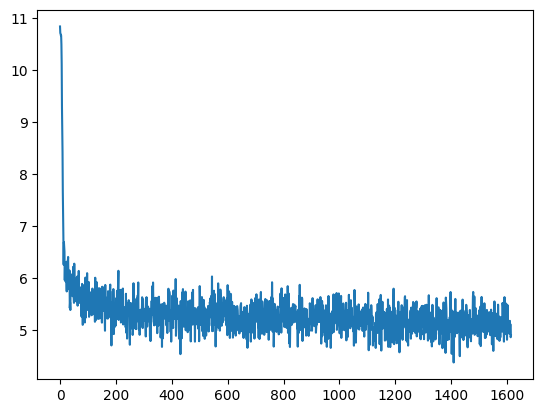

In [37]:
plt.plot(losses)

In [38]:
val_ids_h = [ i for i,_ in val_data["English-Hindi"]["Test"].items()]
print('Length of val_ids_h = ', len(val_ids_h))

Length of val_ids_h =  23085


In [39]:
val_outs_h = []
for i in tqdm(range(len(test_ds_h))):
    # Initialize encoder hidden with correct num_layers
    encoder_hidden, encoder_cell = encoder.initHidden(1) # Initialize with batch size 1
    encoder_hidden = encoder_hidden.to(device)
    encoder_cell = encoder_cell.to(device)

    input_tensor = test_ds_h[i][0].unsqueeze(dim=0).to(device)
    result = []
    with torch.set_grad_enabled(False):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor, (encoder_hidden, encoder_cell)) # Pass both hidden and cell state to the encoder
        decoder_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device)
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell  # Initialize decoder hidden with both hidden and cell state from encoder
        for di in range(1, target_length):
            decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, (decoder_hidden, decoder_cell)) # Pass both hidden and cell state to the decoder
            best = decoder_output.argmax(1)
            result.append(hi_index2word[best.to('cpu').item()])
            if best.item() == EOS:
                break

            decoder_input = best.unsqueeze(dim=0)
    result = [i for i in result if not i in ['<EOS>', '<PAD>', '<SOS>']]
    val_outs_h.append(" ".join(result))

100%|██████████| 23085/23085 [03:04<00:00, 125.05it/s]


In [40]:
df0 = pd.DataFrame()
df0["ID"] = val_ids_h
df0["Translation"] = val_outs_h
df0.to_csv('answersH.csv', index = False)

In [41]:
x_h = pd.read_csv("/content/answersH.csv")
print(x_h.shape)

(23085, 2)


# English --> Bengali

In [18]:
# Prepare training and validation data
source_sentences_train = []
target_sentences_train = []
source_sentences_val = []
target_sentences_val = []
id_train = []
id_val = []

In [19]:
for language_pair, language_data in train_data.items():
    if language_pair == "English-Bengali":
        for data_type, data_entries in language_data.items():
            for entry_id, entry_data in data_entries.items():
                source = entry_data.get("source")
                target = entry_data.get("target")

                if data_type == "Validation":
                    source_sentences_val.append(source)
                    target_sentences_val.append(target)
                    id_val.append(entry_id)
                else:
                    source_sentences_train.append(source)
                    target_sentences_train.append(target)
                    id_train.append(entry_id)

In [20]:
for language_pair, language_data in val_data.items():
    if(language_pair == "English-Bengali"):
      print(f"Language Pair: {language_pair}")
      for data_type, data_entries in language_data.items():
          print(f"  Data Type: {data_type}")
          for entry_id, entry_data in data_entries.items():
              source = entry_data["source"]
              #target = entry_data["target"]
              if (data_type == "Test"):
                source_sentences_val.append(source)
                #target_sentences_val.append(target)
                #id_val.append(entry_id)
              #else:
                #source_sentences_train.append(source)
                #target_sentences_train.append(target)
                #id_train.append(entry_id)

Language Pair: English-Bengali
  Data Type: Test


In [21]:
print(len(source_sentences_train))
print(len(target_sentences_train))

print(len(source_sentences_val))
print(len(target_sentences_val))

68849
68849
19672
0


In [22]:
val_b = pd.DataFrame({'English':source_sentences_val,'Bengali': [None] * len(source_sentences_val)})

In [23]:
val_b

,English,Bengali
0,current events,None
1,The god Brahma was pleased with her penance bu...,None
2,After feeling stiffness in chest or heaviness ...,None
3,As it dawns on him that the baby is in fact hi...,None
4,Australia produces significant amounts of lent...,None
...,...,...
19667,temperature this hour,None
19668,"Today, Arizona is home to one of the largest I...",None
19669,Enclose this mouth freshener in an airtight ja...,None
19670,"Antibiotics, to which the strain is susceptibl...",None


In [24]:
x={'English':source_sentences_train,'Bengali':target_sentences_train}

In [25]:
df_b = pd.DataFrame(x)

In [26]:
df_b

,English,Bengali
0,Do not forget to visit the point where the Nar...,এই জায়গাগুলো দেখতে ভুলো না যেখানে নর্মদা নদী ম...
1,It is evident that the biggest cause of povert...,এই কথা স্পষ্ট যে দরিদ্রতার বড় কারণ হল অশিক্ষা ।
2,The film was released theatrically on 12 April...,চলচ্চিত্রটি ২০১৩ সালের ১২ই এপ্রিল প্রেক্ষাগৃহে...
3,is wyatt's birthday party at ten p. m.,অনিমেষ এর জন্মদিনের পার্টি রাত দশটায়
4,"Apart from being used as an eatable, barley is...",খাদ্যদ্রব্য ছাড়াও যব আরো বিভিন্ন ক্ষেত্রে যেমন...
...,...,...
68844,But it is evident that there is change in both...,তাও এটা প্রত্যক্ষভাবে দেখা যায় যে প্রিন্ট মিড...
68845,Include a detailed listing of all of your prod...,ছবি সহ সম্পূর্ণ করা আপনার সমস্ত পণ্যের একটি বি...
68846,"Each subcategory counts as one page, pages in ...",প্রতিটি উপবিভাগ একটি পৃষ্ঠা হিসাবে গণনা করা হয...
68847,It is one of the country's oldest state-run pu...,এটি দেশের সবচেয়ে পুরনো রাষ্ট্র-চালিত সরকারী বা...


In [51]:
nltk.download('punkt_tab')
english_tokens_b = preprocess(df_b['English'])
english_test_b = preprocess(val_b['English'])
bengali_tokens = preprocess(df_b['Bengali'])
bengali_test = preprocess(val_b['Bengali'])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [52]:
# en - English, bn - Bengali
en_train_b = english_tokens_b
en_test_b = english_test_b
bn_train = bengali_tokens
bn_test = bengali_test

In [53]:
en_index2word_b = ["<PAD>", "<SOS>", "<EOS>"]
bn_index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [en_train_b, en_test_b]:
    for sent in ds:
        for token in sent:
            if token not in en_index2word_b:
                en_index2word_b.append(token)

for ds in [bn_train, bn_test]:
    for sent in ds:
        for token in sent:
            if token not in bn_index2word:
                bn_index2word.append(token)

In [54]:
en_word2index_b = {token: idx for idx, token in enumerate(en_index2word_b)}
bn_word2index = {token: idx for idx, token in enumerate(bn_index2word)}

en_lengths_b = sum([len(sent) for sent in en_train_b])/len(en_train_b)
bn_lengths = sum([len(sent) for sent in bn_train])/len(bn_train)

In [55]:
en_train_encoded_b = [encode_and_pad(en_word2index_b, sent, seq_length) for sent in en_train_b]
en_test_encoded_b = [encode_and_pad(en_word2index_b, sent, seq_length) for sent in en_test_b]
bn_train_encoded = [encode_and_pad(bn_word2index, sent, seq_length) for sent in bn_train]
bn_test_encoded = [encode_and_pad(bn_word2index, sent, seq_length) for sent in bn_test]

In [56]:
batch_size = 50

train_x_b = np.array(en_train_encoded_b)
train_y_b = np.array(bn_train_encoded)
test_x_b = np.array(en_test_encoded_b)
test_y_b = np.array(bn_test_encoded)

train_ds_b = TensorDataset(torch.from_numpy(train_x_b), torch.from_numpy(train_y_b))
test_ds_b = TensorDataset(torch.from_numpy(test_x_b))

train_dl_b = DataLoader(train_ds_b, shuffle=True, batch_size=batch_size, drop_last=True)
#test_dl_b = DataLoader(test_ds_b, shuffle=True, batch_size=batch_size, drop_last=True)

In [57]:
encoder = EncoderLSTM(len(en_index2word_b), hidden_size).to(device)
decoder = DecoderLSTM(hidden_size, len(bn_index2word)).to(device)

In [58]:
criterion = nn.CrossEntropyLoss()
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=3e-3)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=3e-3)

In [59]:
import time

input_length = target_length = seq_length

SOS = en_word2index_b["<SOS>"]
EOS = en_word2index_b["<EOS>"]

epochs = 1
losses = []  # Track losses
start_time = time.time()

for epoch in range(epochs):
    for idx, batch in enumerate(train_dl_b):
        # Get the batch size
        batch_size = batch[0].size(0)

        # Creating initial hidden and cell states for the encoder
        encoder_hidden, encoder_cell = encoder.initHidden(batch_size)

        # Sending initial hidden and cell states to device
        encoder_hidden = encoder_hidden.to(device)
        encoder_cell = encoder_cell.to(device)

        # Assigning the input and target tensors and sending them to the device
        input_tensor = batch[0].to(device)
        target_tensor = batch[1].to(device)

        # Clearing gradients
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # Enable gradient calculation
        with torch.set_grad_enabled(True):
            # Feeding the input batch to the encoder
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor, (encoder_hidden, encoder_cell))

            # Placeholder tensor for decoder outputs
            dec_result = torch.zeros(target_length, batch_size, len(bn_index2word)).to(device)

            # Initialize the decoder input with SOS token for the batch
            decoder_input = torch.tensor([SOS] * batch_size, dtype=torch.long).to(device)

            # Initialize the decoder hidden and cell states with encoder outputs
            decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

            # Decoding step
            max_length = target_tensor.size(1)  # Actual target sequence length
            for i in range(1, max_length):
                # Feed the input token and the hidden states to the decoder
                decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input.unsqueeze(0), (decoder_hidden, decoder_cell))

                # Find the highest scoring word from the decoder output
                best_word = decoder_output.argmax(1)

                # Set the next decoder input to the highest scoring word
                decoder_input = best_word

                # Store the decoder's output in the result placeholder
                dec_result[i] = decoder_output

            # Reshape decoder outputs and targets for loss calculation
            scores = dec_result.transpose(1, 0)[:, 1:max_length, :].reshape(-1, dec_result.shape[2])  # Predicted scores
            targets = target_tensor[:, 1:max_length].reshape(-1)  # Exclude <SOS>

            # Compute the loss (ignore padding tokens)
            loss = criterion(scores, targets)

            # Perform backpropagation and clip gradients
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            # Update the weights
            enc_optimizer.step()
            dec_optimizer.step()

            # Track the loss
            losses.append(loss.item())

            # Print intermediate loss every 100 batches
            if idx % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {idx}, Loss: {sum(losses) / len(losses):.4f}")

end_time = time.time()
training_time = end_time - start_time

Epoch 1, Batch 0, Loss: 11.2743
Epoch 1, Batch 100, Loss: 6.7064
Epoch 1, Batch 200, Loss: 6.2685
Epoch 1, Batch 300, Loss: 6.1297
Epoch 1, Batch 400, Loss: 6.0269
Epoch 1, Batch 500, Loss: 5.9756
Epoch 1, Batch 600, Loss: 5.9320
Epoch 1, Batch 700, Loss: 5.8991
Epoch 1, Batch 800, Loss: 5.8695
Epoch 1, Batch 900, Loss: 5.8500
Epoch 1, Batch 1000, Loss: 5.8273
Epoch 1, Batch 1100, Loss: 5.8101
Epoch 1, Batch 1200, Loss: 5.7954
Epoch 1, Batch 1300, Loss: 5.7799


In [60]:
print("Training time is ", training_time, "seconds")

Training time is  568.9127388000488 seconds


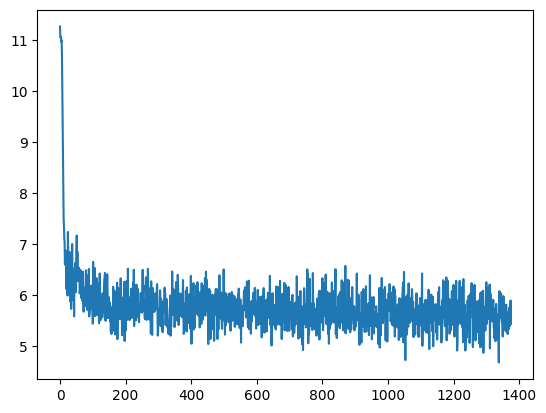

In [61]:
plt.plot(losses)

In [62]:
val_ids_b = [ i for i,_ in val_data["English-Bengali"]["Test"].items()]
print('Length of val_ids_b = ', len(val_ids_b))

Length of val_ids_b =  19672


In [63]:
val_outs_b = []
for i in tqdm(range(len(test_ds_b))):
    # Initialize encoder hidden with correct num_layers
    encoder_hidden, encoder_cell = encoder.initHidden(1)  # Initialize with batch size 1
    encoder_hidden = encoder_hidden.to(device)
    encoder_cell = encoder_cell.to(device)

    input_tensor = test_ds_b[i][0].unsqueeze(dim=0).to(device)
    result = []
    with torch.set_grad_enabled(False):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor, (encoder_hidden, encoder_cell))  # Pass both hidden and cell state to the encoder
        decoder_input = torch.tensor([SOS]).unsqueeze(dim=0).to(device)
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell  # Initialize decoder hidden with both hidden and cell state from encoder
        for di in range(1, target_length):
            decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, (decoder_hidden, decoder_cell))  # Pass both hidden and cell state to the decoder
            best = decoder_output.argmax(1)
            result.append(bn_index2word[best.to('cpu').item()])
            if best.item() == EOS:
                break

            decoder_input = best.unsqueeze(dim=0)
    result = [i for i in result if not i in ['<EOS>', '<PAD>', '<SOS>']]
    val_outs_b.append(" ".join(result))

100%|██████████| 19672/19672 [02:21<00:00, 139.22it/s]


In [64]:
df0 = pd.DataFrame()
df0["ID"] = val_ids_b
df0["Translation"] = val_outs_b
df0.to_csv('answersB.csv', index = False)

In [65]:
x_b = pd.read_csv("/content/answersB.csv")
print(x_b.shape)

(19672, 2)


# Final data

In [66]:
df = pd.concat([x_b,x_h])

In [67]:
df.to_csv('answersBH.csv', index = False)
df_final = pd.read_csv("/content/answersBH.csv")

In [68]:
df_final.shape

(42757, 2)

In [69]:
df_final.head()

,ID,Translation
0,177039,আমর ক
1,177040,এই এই য য য য এব এব এব এব এব এব এব এব
2,177041,তন তন য য য য য তর এব এব এব এব এব এব
3,177042,এট এব এব এব এব এব এব এব এব এব এব এব এব এব
4,177043,এই কর কর কর


In [ ]:
answer = "/content/answer.csv"
with open(answer, "w") as f:
  f.writelines("ID\tTranslation\n")
  for i in range(df_final.shape[0]):
    f.writelines(f'{df_final["ID"][i]}\t"{df_final["Translation"][i]}"\n')

In [ ]:
d = pd.read_csv("answer_f.csv",header = None)

In [ ]:
d.shape

(42758, 2)

English Sentence Length Stats:
count    149646.000000
mean         16.955121
std           8.959481
min           1.000000
25%          11.000000
50%          16.000000
75%          22.000000
max         257.000000
Name: English, dtype: float64

Hindi Sentence Length Stats:
count    149646.000000
mean         10.681736
std          11.926170
min           1.000000
25%           1.000000
50%           6.000000
75%          18.000000
max         216.000000
Name: Hindi, dtype: float64

Bengali Sentence Length Stats:
count    149646.000000
mean          7.106364
std           8.226763
min           1.000000
25%           1.000000
50%           1.000000
75%          12.000000
max          84.000000
Name: Bengali, dtype: float64

Top 10 most common English words:
[('the', 143277), ('of', 97530), ('and', 66158), ('in', 56142), ('.', 53701), ('is', 52005), ('to', 51848), ('a', 40633), (',', 24249), ('The', 20255)]

Top 10 most common Hindi words:
[('nan', 68852), ('के', 62641), ('में', 45206),

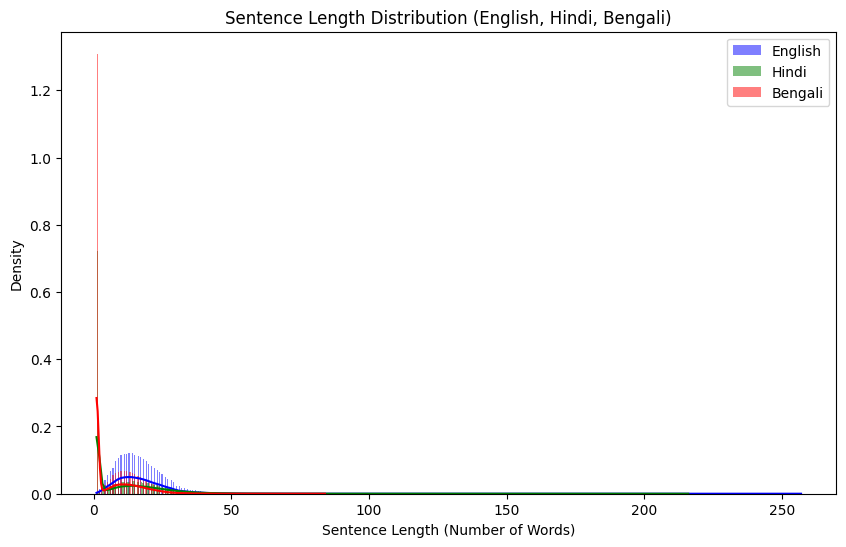

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Load the datasets (assuming they are stored as CSV files)
english_hindi_df = df_h
english_bengali_df =df_b
# Combine both DataFrames for overall analysis
combined_df = pd.concat([english_hindi_df, english_bengali_df])

# Sentence length statistics for English, Hindi, and Bengali
english_sentence_lengths = combined_df['English'].apply(lambda x: len(str(x).split())) # Convert to string before splitting
hindi_sentence_lengths = combined_df['Hindi'].apply(lambda x: len(str(x).split())) # Convert to string before splitting
bengali_sentence_lengths = combined_df['Bengali'].apply(lambda x: len(str(x).split())) # Convert to string before splitting

# Summary statistics for sentence lengths
print("English Sentence Length Stats:")
print(english_sentence_lengths.describe())

print("\nHindi Sentence Length Stats:")
print(hindi_sentence_lengths.describe())

print("\nBengali Sentence Length Stats:")
print(bengali_sentence_lengths.describe())

# Word Frequency Analysis
english_words = ' '.join(combined_df['English']).split()
hindi_words = ' '.join(combined_df['Hindi'].astype(str)).split()
bengali_words = ' '.join(combined_df['Bengali'].astype(str)).split()

# Word count
english_word_counts = Counter(english_words)
hindi_word_counts = Counter(hindi_words)
bengali_word_counts = Counter(bengali_words)

# Display most common words
print("\nTop 10 most common English words:")
print(english_word_counts.most_common(10))

print("\nTop 10 most common Hindi words:")
print(hindi_word_counts.most_common(10))

print("\nTop 10 most common Bengali words:")
print(bengali_word_counts.most_common(10))

# Visualization: Sentence Length Distribution
plt.figure(figsize=(10,6))
sns.histplot(english_sentence_lengths, color='blue', label='English', kde=True, stat='density', linewidth=0)
sns.histplot(hindi_sentence_lengths, color='green', label='Hindi', kde=True, stat='density', linewidth=0)
sns.histplot(bengali_sentence_lengths, color='red', label='Bengali', kde=True, stat='density', linewidth=0)
plt.legend()
plt.title('Sentence Length Distribution (English, Hindi, Bengali)')
plt.xlabel('Sentence Length (Number of Words)')
plt.ylabel('Density')
plt.show()